In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.translation_utils import *
from utils.decomposition_utils import *
from utils.plot_utils import *

warnings.filterwarnings('ignore')

## Compute geometric information

In [25]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.interpolate import interpn, RectBivariateSpline
from scipy.io import loadmat
from utils.decomposition_utils import *


with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    ap = h5f['ensemble/links/m_ij/AP_coordinates'][0, :][()]
    dv = h5f['ensemble/links/m_ij/DV_coordinates'][:, 0][()]
    dAP = ap[1]-ap[0]
    dDV = dv[1]-dv[0]
    YX = np.stack(np.meshgrid(dv, ap, indexing='ij'), axis=-1)
    
diff_args = dict(
    dAP=dAP,
    dDV=dDV,
    sigma=5, 
)

def embryo_pad(x0, pad_width=20, dv_pad='wrap', ap_pad='edge', **kwargs):
    x = x0.reshape([-1, *x0.shape[-2:]])
    x = np.pad(x, ((0, 0), (pad_width, pad_width), (0, 0)), mode=dv_pad)
    x = np.pad(x,  ((0, 0), (0, 0), (pad_width, pad_width)), mode=ap_pad)
    x = x.reshape([*x0.shape[:-2], *x.shape[-2:]])
    '''
    Since we reflected along the x axis, we have to 
    adjust vector/tensor components in the reflected region
    '''
    if ap_pad in ['reflect', 'symmetric']:
        if len(x.shape) == 3: #Vector
            x[1, :,  :pad_width] *= -1
            x[1, :, -pad_width:] *= -1

        elif len(x.shape) == 4: #Tensor
            x[0, 1, :,  :pad_width] *= -1
            x[0, 1, :, -pad_width:] *= -1
            x[1, 0, :,  :pad_width] *= -1
            x[1, 0, :, -pad_width:] *= -1
    return x

def gradient(x0, dDV=2.7, dAP=2.7, sigma=5, **pad_kwargs):
    pad_width=4*sigma
    x = embryo_pad(x0, pad_width=pad_width, **pad_kwargs)

    dY_x = gaussian_filter1d(x, axis=-2, sigma=sigma, order=1, mode='nearest') / dDV
    dX_x = gaussian_filter1d(x, axis=-1, sigma=sigma, order=1, mode='nearest') / dAP
    return np.stack([
        dY_x[..., pad_width:-pad_width, pad_width:-pad_width],
        dX_x[..., pad_width:-pad_width, pad_width:-pad_width]
    ], axis=-1)

geo_dir = '../flydrive.synology.me/Public/dynamic_atlas/embryo_geometry'
geometry = loadmat(os.path.join(geo_dir, 'embryo_rectPIVscale_fundamentalForms.mat'), simplify_cells=True)
print(geometry['readme'])
#Convert to microns
X0g = geometry['X0'][0, :] * 0.2619 / 0.4
Y0g = geometry['Y0'][:, 0] * 0.2619 / 0.4
print('Metric Extent: %.3f %.3f %.3f %.3f' % (
    X0g.min(), X0g.max(), Y0g.min(), Y0g.max()))
print('Data Extent: %.3f %.3f %.3f %.3f' % (
    ap.min(), ap.max(), dv.min(), dv.max()))

#Interpolate metric onto evaluation points
gg = geometry['ggPIV']
gg = np.stack([g for g in gg], axis=0)
gg = np.stack([g for g in gg], axis=0).reshape([X0g.shape[0], Y0g.shape[0], 2, 2])
gg = gg.transpose(1, 0, 2, 3)
gg[..., 0, 1] = 0 #Eliminate off-diagonal metric components
gg[..., 1, 0] = 0 #Eliminate off-diagonal metric components
gg = np.broadcast_to(gg.mean(axis=0, keepdims=True), gg.shape) #Remove DV variation
gg = gg[..., ::-1, ::-1] #Swap y, x coordinates

gij = []
gg = gg.reshape([*gg.shape[:2], 4])
for i in range(gg.shape[-1]):
    gij.append(RectBivariateSpline(Y0g, X0g, gg[..., i])(dv, ap))
gij = np.stack(gij, axis=-1).reshape([dv.shape[0], ap.shape[0], 2, 2])
ginv = np.linalg.inv(gij)

#Print out metric information as a check
np.set_printoptions(precision=3, suppress=True)
print('Metric at (0, 0)\n', gij[0, 0])
print('Inverse metric at (0, 0)\n', ginv[0, 0])

#Build Christoffel symbols
gij_k = gradient(gij.transpose(2, 3, 0, 1), **diff_args)
gij_k = gij_k.transpose(2, 3, 0, 1, 4)

Gijk =  0.5 * (
    np.einsum('yxil,yxjlk->yxijk', ginv, gij_k) + \
    np.einsum('yxil,yxlkj->yxijk', ginv, gij_k) - \
    np.einsum('yxil,yxjkl->yxijk', ginv, gij_k)
)
print('Christoffel Symbol Shape: ', Gijk.shape)

fig, ax = plt.subplots(2, 2, dpi=200, figsize=(2, 2))
ij = ['y', 'x']
vmin = np.min(gij)
vmax = np.max(gij)
for i in range(2):
    for j in range(2):
        color_2D(ax[i, j], gij[..., i, j], cmap='Reds', vmin=vmin, vmax=vmax)
        ax[i, j].set_title('$g_{%s %s}$' % (ij[i], ij[j]))
        ax[i, j].set_aspect('auto')
plt.tight_layout()

fig, ax = plt.subplots(2, 4, dpi=200, figsize=(4, 2))
vmin = np.min(Gijk)
vmax = np.max(Gijk)
for i in range(2):
    for j in range(2):
        for k in range(2):
            color_2D(ax[i, 2*k+j], Gijk[..., i, j, k], cmap='Reds')#, vmin=vmin, vmax=vmax)
            ax[i, 2*k+j].set_title('$\\Gamma^{%s}_{%s %s}$' % (ij[i], ij[j], ij[k]))
            ax[i, 2*k+j].set_aspect('auto')
plt.tight_layout()

np.save('Public/christoffel_symbols', Gijk)


def covariant_gradient(x0, **diff_args):
    grad_x = gradient(x0, **diff_args)

    if len(x0.shape) == 3: #Vector
        grad_x += np.einsum('yxijk,kyx->iyxj', Gijk, x0)
        #grad_x -= np.einsum('yxkij,kyx->iyxj', Gijk, x0)
    elif len(x0.shape) == 4: #Tensor
        grad_x += np.einsum('yxikl,ljyx->ijyxk', Gijk, x0) + \
                  np.einsum('yxjkl,ilyx->ijyxk', Gijk, x0)
        #grad_x -= np.einsum('yxlik,ljyx->ijyxk', Gijk, x0) + \
        #          np.einsum('yxljk,ilyx->ijyxk', Gijk, x0)
    return grad_x

KeyError: 'Unable to open object (component not found)'

## Load geometric information

In [2]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.interpolate import interpn, RectBivariateSpline
from scipy.io import loadmat
from utils.decomposition_utils import *


with h5py.File('Public/raw_dynamics_fitting.h5', 'r') as h5f:
    ap = h5f['ensemble/links/m_ij/AP_coordinates'][0, :][()]
    dv = h5f['ensemble/links/m_ij/DV_coordinates'][:, 0][()]
    dAP = ap[1]-ap[0]
    dDV = dv[1]-dv[0]
    YX = np.stack(np.meshgrid(dv, ap, indexing='ij'), axis=-1)

geo_dir = '../flydrive.synology.me/Public/dynamic_atlas/embryo_geometry'
geometry = loadmat(os.path.join(geo_dir, 'embryo_rectPIVscale_fundamentalForms.mat'), simplify_cells=True)
#Convert to microns
X0g = geometry['X0'][0, :] * 0.2619 / 0.4
Y0g = geometry['Y0'][:, 0] * 0.2619 / 0.4
print('Metric Extent: %.3f %.3f %.3f %.3f' % (
    X0g.min(), X0g.max(), Y0g.min(), Y0g.max()))
print('Data Extent: %.3f %.3f %.3f %.3f' % (
    ap.min(), ap.max(), dv.min(), dv.max()))

Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
print('Loaded Christoffel symbols from Public')

def embryo_pad(x0, pad_width=20, dv_pad='wrap', ap_pad='edge', **kwargs):
    x = x0.reshape([-1, *x0.shape[-2:]])
    x = np.pad(x, ((0, 0), (pad_width, pad_width), (0, 0)), mode=dv_pad)
    x = np.pad(x,  ((0, 0), (0, 0), (pad_width, pad_width)), mode=ap_pad)
    x = x.reshape([*x0.shape[:-2], *x.shape[-2:]])
    '''
    Since we reflected along the x axis, we have to 
    adjust vector/tensor components in the reflected region
    '''
    if ap_pad in ['reflect', 'symmetric']:
        if len(x.shape) == 3: #Vector
            x[1, :,  :pad_width] *= -1
            x[1, :, -pad_width:] *= -1

        elif len(x.shape) == 4: #Tensor
            x[0, 1, :,  :pad_width] *= -1
            x[0, 1, :, -pad_width:] *= -1
            x[1, 0, :,  :pad_width] *= -1
            x[1, 0, :, -pad_width:] *= -1
    return x

def gradient(x0, dDV=2.7, dAP=2.7, sigma=5, **pad_kwargs):
    pad_width=4*sigma
    x = embryo_pad(x0, pad_width=pad_width, **pad_kwargs)

    dY_x = gaussian_filter1d(x, axis=-2, sigma=sigma, order=1, mode='nearest') / dDV
    dX_x = gaussian_filter1d(x, axis=-1, sigma=sigma, order=1, mode='nearest') / dAP
    return np.stack([
        dY_x[..., pad_width:-pad_width, pad_width:-pad_width],
        dX_x[..., pad_width:-pad_width, pad_width:-pad_width]
    ], axis=-1)

def covariant_gradient(x0, **diff_args):
    grad_x = gradient(x0, **diff_args)

    if len(x0.shape) == 3: #Vector
        grad_x += np.einsum('yxijk,kyx->iyxj', Gijk, x0)
        #grad_x -= np.einsum('yxkij,kyx->iyxj', Gijk, x0)
    elif len(x0.shape) == 4: #Tensor
        grad_x += np.einsum('yxikl,ljyx->ijyxk', Gijk, x0) + \
                  np.einsum('yxjkl,ilyx->ijyxk', Gijk, x0)
        #grad_x -= np.einsum('yxlik,ljyx->ijyxk', Gijk, x0) + \
        #          np.einsum('yxljk,ilyx->ijyxk', Gijk, x0)
    return grad_x

Metric Extent: 4.911 446.867 4.911 525.437
Data Extent: 3.230 455.701 3.227 536.891
Loaded Christoffel symbols from Public


# Integrating both models simultaneously

Integration status:  0 The solver successfully reached the end of the integration interval.


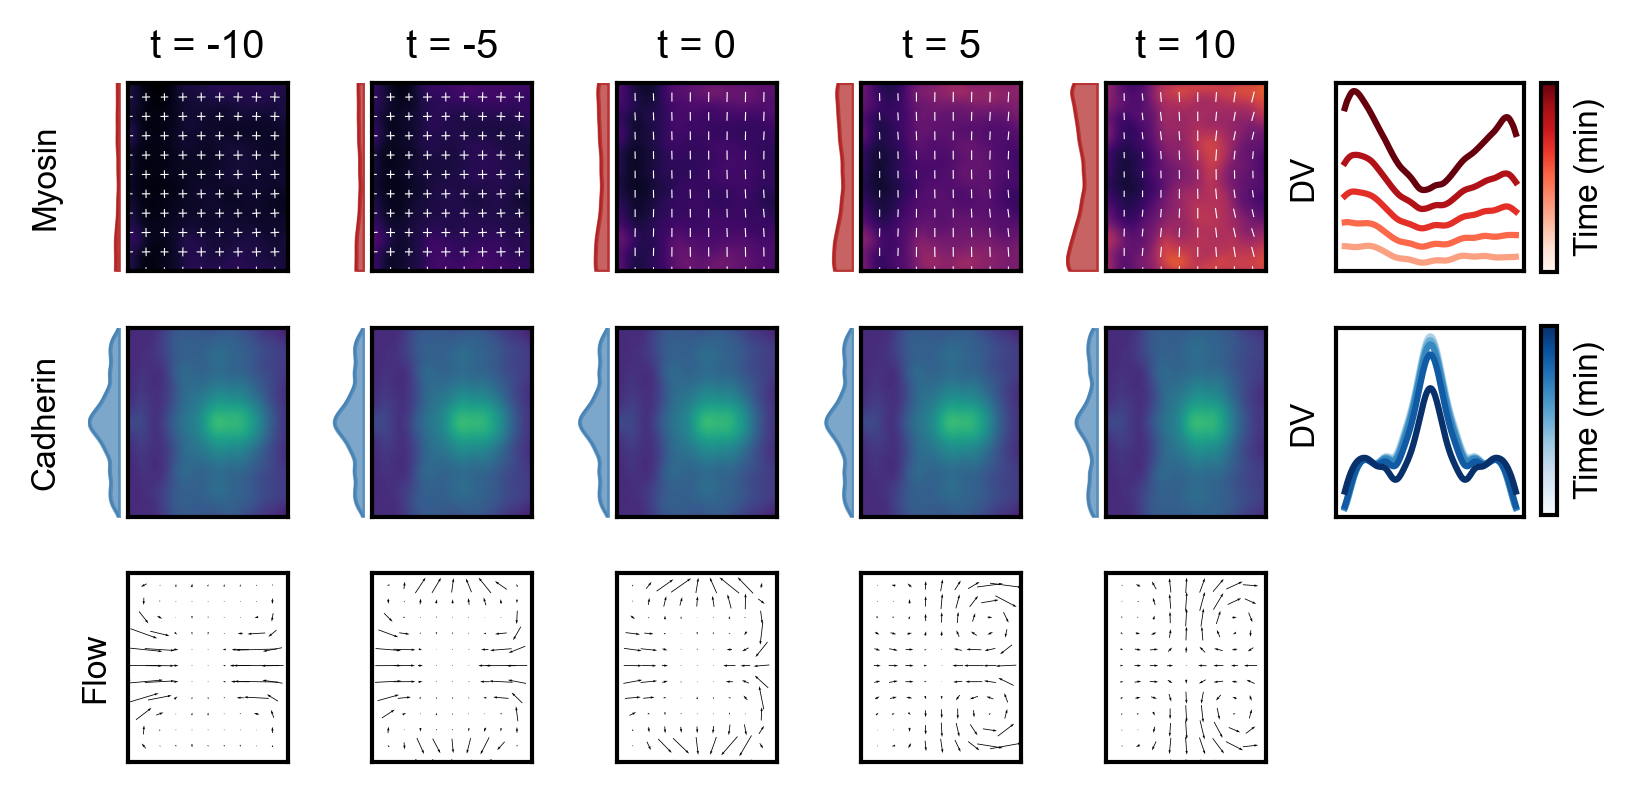

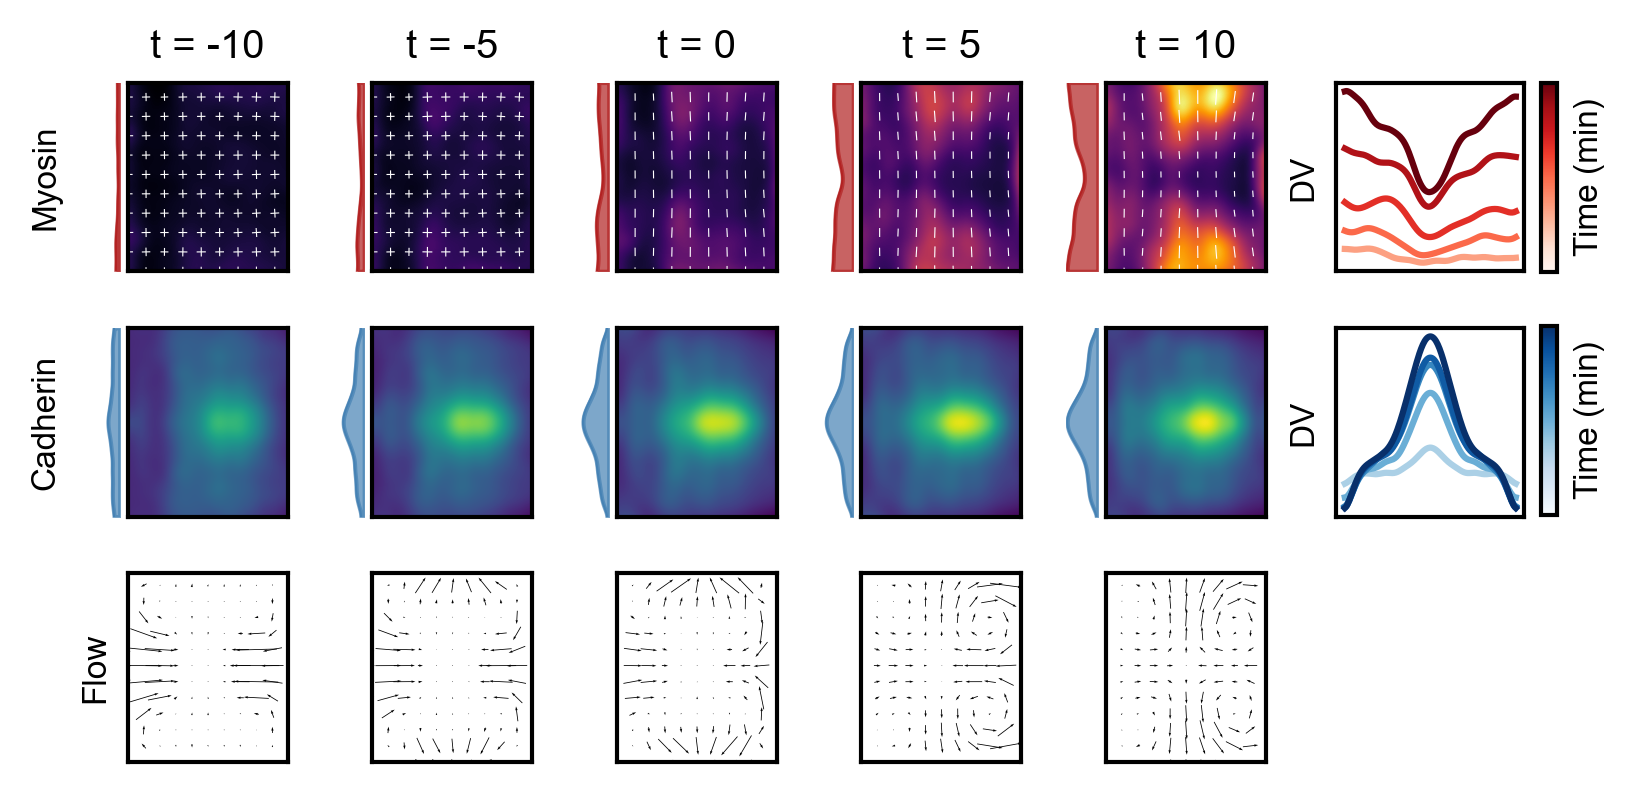

In [5]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'

def plot_with_cuts(ax, z, **kwargs):
    try:
        plot_tensor2D(ax, z, **kwargs)
    except:
        color_2D(ax, z, **kwargs)
    
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
        
    N0, N1 = 20, 80
    cut_Y = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
    return cut_Y
    
def plot(m, c, v, t, N=5, mmin=None, mmax=None, cmin=None, cmax=None, mask=None):
    dynamic_mask = np.load('Public/Masks/Dynamic_PMG_CF_mask.npy', mmap_mode='r')
    dynamic_time = np.load('Public/Masks/Dynamic_PMG_CF_time.npy', mmap_mode='r')
    msk = interp1d(dynamic_time, dynamic_mask, axis=0, fill_value='extrapolate')

    dt = (len(m)-1) // (N-1)

    fig1, ax1 = plt.subplots(3, N+1, figsize=(N*0.9+1, 3), dpi=300)

    #Boundary crop
    if mask is None:
        mask = np.s_[...]

    if mmin is None:
        mnorm = np.linalg.norm(m[mask], axis=(1, 2))[..., :-20]
        mmin = np.min(mnorm)
        mmax = np.max(mnorm)
    if cmin is None:
        cmin = np.min(c[mask])
        cmax = np.max(c[mask])
        
    cut_cad = []
    cut_sqh = []
    offset = 20
    for i in range(N):
        ax1[0, i].set_title('t = %d' % (t[dt*i]))
        
        alpha = msk(t[dt*i]).astype(float)[mask]
        alpha[alpha == 0] = 1

        s1 = plot_with_cuts(ax1[0, i], m[dt*i][mask], 
            cmap='inferno', vmin=mmin, vmax=mmax, both=t[dt*i]<0, alpha=alpha)    
        c1 = plot_with_cuts(ax1[1, i], c[dt*i][mask],
            cmap='viridis', vmin=cmin, vmax=cmax, alpha=alpha)
        cut_cad.append(c1)
        cut_sqh.append(s1)
        y = np.linspace(*ax1[0, i].get_ylim(), len(s1))
    
        sqh_color=plt.get_cmap('Reds')((t[dt*i] + offset)/ (np.max(t) + offset))
        cad_color=plt.get_cmap('Blues')((t[dt*i] + offset)/ (np.max(t) + offset))

        ax1[0, -1].plot(y, s1, color=sqh_color)
        ax1[1, -1].plot(y, c1, color=cad_color)

        plot_vector2D(ax1[2, i], v[dt*i], skip=20)
        ax1[2, -1].set_visible(False)
    
    for i in range(N):
        cuts = [cut_sqh[i], cut_cad[i]]
        axes = ax1[:2, i]
        colors = ['firebrick', 'steelblue']
        for cut, ax, color, ax2 in zip(cuts, axes, colors, ax1[:2, -1]):
            y = np.linspace(*ax.get_ylim(), len(cut))

            ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
            ax_Y.plot(cut, y, color=color, lw=0.5)
            ax_Y.fill_betweenx(y, np.ones_like(cut)*ax2.get_ylim()[0], cut,
                               color=color, alpha=0.7)
    
            ax_Y.set(xticks=[], yticks=[])
            ax_Y.set_xlim(ax2.get_ylim())
            ax_Y.invert_xaxis()
            ax_Y.axis('off')
            
    ax1[0, -1].set(xticks=[], yticks=[], ylabel='DV')    
    ax1[1, -1].set(xticks=[], yticks=[], ylabel='DV')    

    lp=16
    ax1[0, 0].set_ylabel('Myosin', labelpad=lp)
    ax1[1, 0].set_ylabel('Cadherin', labelpad=lp)
    ax1[2, 0].set_ylabel('Flow')

    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-20, vmax=np.max(t))
    fig1.subplots_adjust(right=0.98, wspace=0.3, hspace=0.3)


    cax = fig1.add_axes([0.99, 0.67, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 cax=cax, label='Time (min)', ticks=[])
    cax = fig1.add_axes([0.99, 0.4, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
                 cax=cax, label='Time (min)', ticks=[])
    
    for i in range(ax1.shape[0]):
        for j in range(ax1.shape[1]-1):
            ax1[i, j].set_aspect('equal')

def rhs(t, y, v_int, ds_int, diff_args, nDV=236, nAP=200):
    mc = y.reshape([5, nDV, nAP])
    m = mc[:4].reshape([2, 2, nDV, nAP])
    c = mc[4:].squeeze()

    d1_m = covariant_gradient(m, **diff_args)
    d1_c = covariant_gradient(c, **diff_args)
    v = v_int(t)
    d1_v = covariant_gradient(v, **diff_args)

    O = -0.5 * (np.einsum('iyxj->ijyx', d1_v) - np.einsum('jyxi->ijyx', d1_v))
    E = 0.5 * (np.einsum('iyxj->ijyx', d1_v) + np.einsum('jyxi->ijyx', d1_v))

    deviatoric = m - 0.5 * np.einsum('kkyx,ij->ijyx', m, np.eye(2))

    m_0 = np.linalg.norm(m, axis=(0, 1), keepdims=True).mean(axis=(2, 3), keepdims=True)
    dev_mag = np.linalg.norm(deviatoric, axis=(0, 1), keepdims=True)

    devE = np.einsum('klyx,klyx->yx', deviatoric, E)[None, None]

    E_active = E - np.sign(devE) * devE * deviatoric / dev_mag**2
    E_active = 0.5 * E_active * dev_mag / m_0 
    E_passive = E - E_active

    mE = np.einsum('ikyx,kjyx->ijyx', m, E_passive) + np.einsum('ikyx,kjyx->ijyx', E_passive, m) 

    ds = ds_int(t)
    dv = gamma_dv[:, :, None, None]
    trm = np.einsum('kkyx->yx', m)
    trE = np.einsum('kyxk->yx', d1_v)

    #D_t c = -0.025 c + 0.064 c trE + 0.261 Gamma^D
    cdot =  -1.000 * np.einsum('iyx,yxi->yx', v, d1_c)
    #cdot +=  0.025 * ds - 0.006 * c
    #cdot += 0.102 * ds - 0.013 * c + 0.348 * c * trE
    #cdot += 0.027 + 0.025 * ds - 0.023 * c + 2 * (c - 1) * trE
    
    trm = trm[None, None]
    c = c[None, None]

    mdot =  -1.000 * np.einsum('kyx,ijyxk->ijyx', v, d1_m)
    mdot -= +1.000 * np.einsum('ikyx,kjyx->ijyx', O, m)
    mdot -= -1.000 * np.einsum('ikyx,kjyx->ijyx', m, O)
    mdot += -0.007 * m
    mdot += -(0.668 - 1.072 * c) * mE
    mdot += trm * (0.007 * dv + 0.209 * m)
    #mdot += -0.2 * m
    #mdot += (3.2 - 1.5 * c) * mE
    #mdot += trm * (0.2 * dv + 0.1 * m)
    
    #mdot += -0.043 * m
    #mdot += (1.617 - 0.876 * c) * mE
    #mdot += (0.02 * dv + 0.339 * m) * trm

    mcdot = np.concatenate([
        mdot.reshape([4, nDV, nAP]),
        cdot.reshape([1, nDV, nAP]),
    ])

    return mcdot.flatten()
    
def integrate(m0, c0, v0, gamma_d0, gamma_dv, t, YY, XX, t_eval=None):
    '''
    Integrate two fields m, c according to SINDy-identified equations
    Include a co-evolving velocity field and two source fields
    ''' 
    #Set up interpolators for control fields
    v_int = interp1d(t, v0, axis=0)
    ds_int = interp1d(t, gamma_d0, axis=0)
    
    #Set up differentiators
    nDV = YY.shape[0]
    nAP = XX.shape[0]
    
    dAP = XX[1] - XX[0]
    dDV = YY[1] - YY[0]
    diff_args = dict(
        dAP=dAP,
        dDV=dDV,
        sigma=3, 
    )

    mc0 = np.concatenate([
        m0.reshape([4, nDV, nAP]),
        c0.reshape([1, nDV, nAP])
    ])
    
    y0 = mc0.flatten()
    if t_eval is None:
        t_eval = t
    out = solve_ivp(rhs, [t[0], t[-1]], y0, t_eval=t_eval, 
                    args=(v_int, ds_int, diff_args, nDV, nAP))
    print('Integration status: ', out['status'], out['message'])
    mc = out['y'].T.reshape([-1, 5, nDV, nAP])
    m = mc[:, :4].reshape([-1, 2, 2, nDV, nAP])
    c = mc[:, 4:].reshape([-1, nDV, nAP])
    v = v_int(t_eval)
    
    return m, c, v, out['t']

from utils.decomposition_utils import LeftRightSymmetrize
with h5py.File('Public/raw_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin = -10
    tmax = 10
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    
    m0 = data['fields/m_ij'][t_mask, ...][()]
    c0 = data['fields/c'][t_mask, ...][()]
    v = data['fields/v'][t_mask, ...][()]
    gamma_d = data['X_raw/Dorsal_Source'][t_mask, ...]
    gamma_dv = data['X_raw/Static_DV'][0, :, :, 0, 0]
    
    sigma = 10
    gamma_d = gaussian_filter(gamma_d, sigma=(0, sigma, sigma))
    v = LeftRightSymmetrize().fit_transform(v)
    c0 = LeftRightSymmetrize().fit_transform(c0)
    
    t0 = t[t_mask, ...]
    
    v_int = interp1d(t0, v, axis=0)
    ds_int = interp1d(t0, gamma_d, axis=0)
    
    mask = np.s_[..., 20:-20, 0:-25]
    
    #If we're using synthetic ICs
    '''
    m0_norm = np.linalg.norm(m0[0], axis=(0, 1)).mean()
    m0_syn = np.array([[1, 0], [0, .95]]) * m0_norm
    m0_syn = np.broadcast_to(m0_syn[..., None, None], m0[0].shape)

    c0_min, c0_max = np.min(c0[0, :, 50:-50]), np.max(c0[0, :, 50:-50])
    dv_gradient = np.linspace(c0_min, c0_max, 236//2)
    c0_syn = np.concatenate([dv_gradient, dv_gradient[::-1]])
    c0_syn = np.broadcast_to(c0_syn[:, None], c0[0].shape)

    v = v_int(t0)
    m, c, v, t = integrate(m0_syn, c0_syn, v, gamma_d, gamma_dv, t0, dv, ap)
    plot(m, c, v, t, N=5, mask=mask)
    '''
    
    #If we're comparing with experimental data
    #v = v_int(t0)
    m, c, v, t = integrate(m0[0], c0[0], v, gamma_d, gamma_dv, t0, dv, ap)
    
    mnorm = np.linalg.norm(m0, axis=(1, 2))
    mmin = np.min(mnorm)
    mmax = np.max(mnorm)
    cmin = np.min(c0)
    cmax = np.max(c0)
    
    plot(m, c, v, t, N=5, mmin=mmin, mmax=mmax, cmin=cmin, cmax=cmax, mask=mask)
    plot(m0, c0, v, t, N=5, mmin=mmin, mmax=mmax, cmin=cmin, cmax=cmax, mask=mask)
    #plt.savefig('Figures/MyoCad_Integration.svg', bbox_inches='tight')

(21,) (21,)


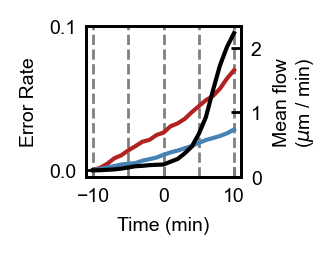

In [71]:
#Demonstrate ensemble of cell trajectories
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['xtick.major.width'] = 1.
plt.rcParams['ytick.major.width'] = 1.
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.titlesize'] = 7

fig, ax = plt.subplots(figsize=(1., 1.))

for tt in [-10, -5, 0, 5, 10]:
    ax.axvline(tt, color='grey', linestyle='--', linewidth=1)


ax2 = ax.twinx()
ax2.plot(t, np.linalg.norm(v, axis=1).mean(axis=(1, 2)), color='black')
ax.set_xticks([-10, 0, 10])
ax.set_xlabel('Time (min)')
ax2.set_ylabel('Mean flow\n($\mu$m / min)')
ax2.set_yticks([0, 1, 2])

    
res_m = mean_norm_residual(m0[mask], m[mask]).mean(axis=(1, 2))
res_c = residual(c0[mask], c[mask]).mean(axis=(1, 2))

print(res_m.shape, res_c.shape)

ax.plot(t, res_m, color='firebrick')
ax.plot(t, res_c, color='steelblue')
ax.set_ylabel('Error Rate')
ax.set_ylim([-0.005, 0.1])
ax.set_yticks([0, 0.1])

plt.savefig('Figures/ClosedLoop_Accuracy.svg', bbox_inches='tight')

Text(0.5, 1.0, 'Cadherin (t = -10)')

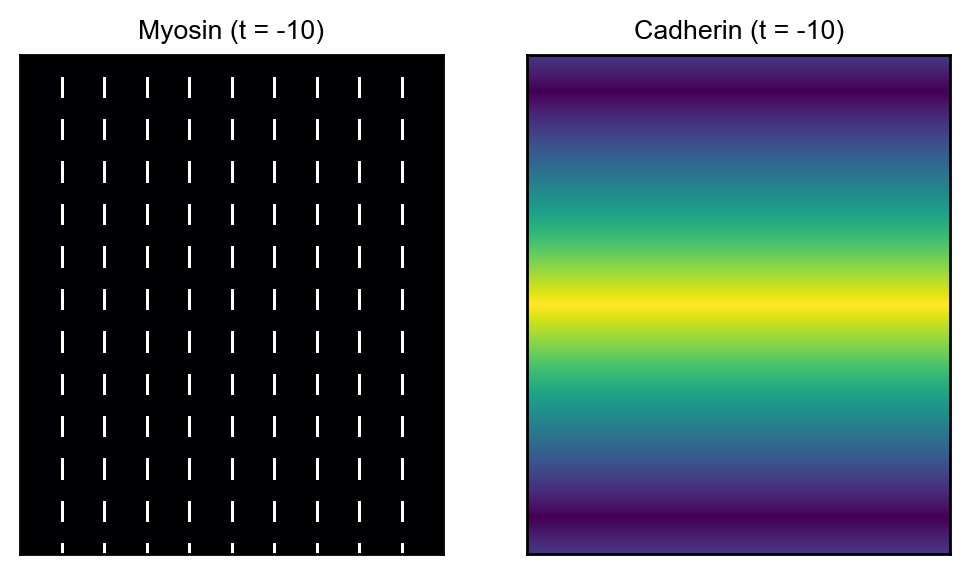

In [15]:
#Synthetic initial condition

m0_norm = np.linalg.norm(m0[0], axis=(0, 1)).mean()
m0_syn = np.array([[1, 0], [0, 0.5]]) * m0_norm
m0_syn = np.broadcast_to(m0_syn[..., None, None], m0[0].shape)

c0_min, c0_max = np.min(c0[0, :, 50:-50]), np.max(c0[0, :, 50:-50])
dv_gradient = np.linspace(c0_min, c0_max, 236//2)
c0_syn = np.concatenate([dv_gradient, dv_gradient[::-1]])
c0_syn = np.broadcast_to(c0_syn[:, None], c0[0].shape)

fig, ax = plt.subplots(1, 2, dpi=200)
plot_tensor2D(ax[0], m0_syn)
color_2D(ax[1], embryo_pad(c0_syn), cmap='viridis')

ax[0].set_title('Myosin (t = -10)')
ax[1].set_title('Cadherin (t = -10)')

# Integrating ICs from mutant data

(107, 2, 2, 236, 200) (107, 2, 236, 200)


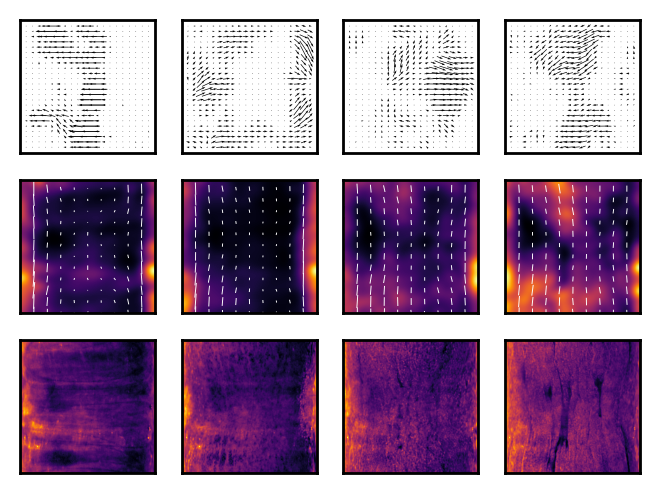

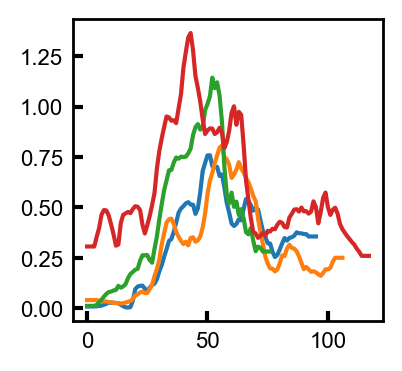

In [178]:
loaddir = 'Public/toll[RM9]/Sqh-GFP/'
loaddir = 'Public/spaetzle[A]/Sqh-GFP'
df = pd.read_csv(os.path.join(loaddir, 'dynamic_index.csv'))
embryoIDs = df.embryoID.unique()
i = 1
eId = embryoIDs[i]
edir = os.path.join(loaddir, str(eId))

raw = np.load(os.path.join(edir, 'raw2D.npy'), mmap_mode='r')
m = np.load(os.path.join(edir, 'tensor2D.npy'), mmap_mode='r')
v = np.load(os.path.join(edir, 'velocity2D.npy'), mmap_mode='r')
print(m.shape, v.shape)

fig, ax = plt.subplots(3, 4, figsize=(4, 3), dpi=200)
for i, tt in enumerate(np.linspace(0, m.shape[0]-1, 4, dtype=int)):
    plot_vector2D(ax[0, i], v[tt])
    plot_tensor2D(ax[1, i], m[tt])
    color_2D(ax[2, i], raw[tt])
    ax[0, i].set_aspect('auto')
    ax[1, i].set_aspect('auto')
    ax[2, i].set_aspect('auto')

fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=200)

for eId in embryoIDs:
    edir = os.path.join(loaddir, str(eId))
    v = np.load(os.path.join(edir, 'velocity2D.npy'), mmap_mode='r')
    ax.plot(np.arange(v.shape[0]), np.linalg.norm(v, axis=1).mean(axis=(1, 2)))


(21, 2, 2, 236, 200) (21, 2, 236, 200)
(21,)
Integration status:  0 The solver successfully reached the end of the integration interval.


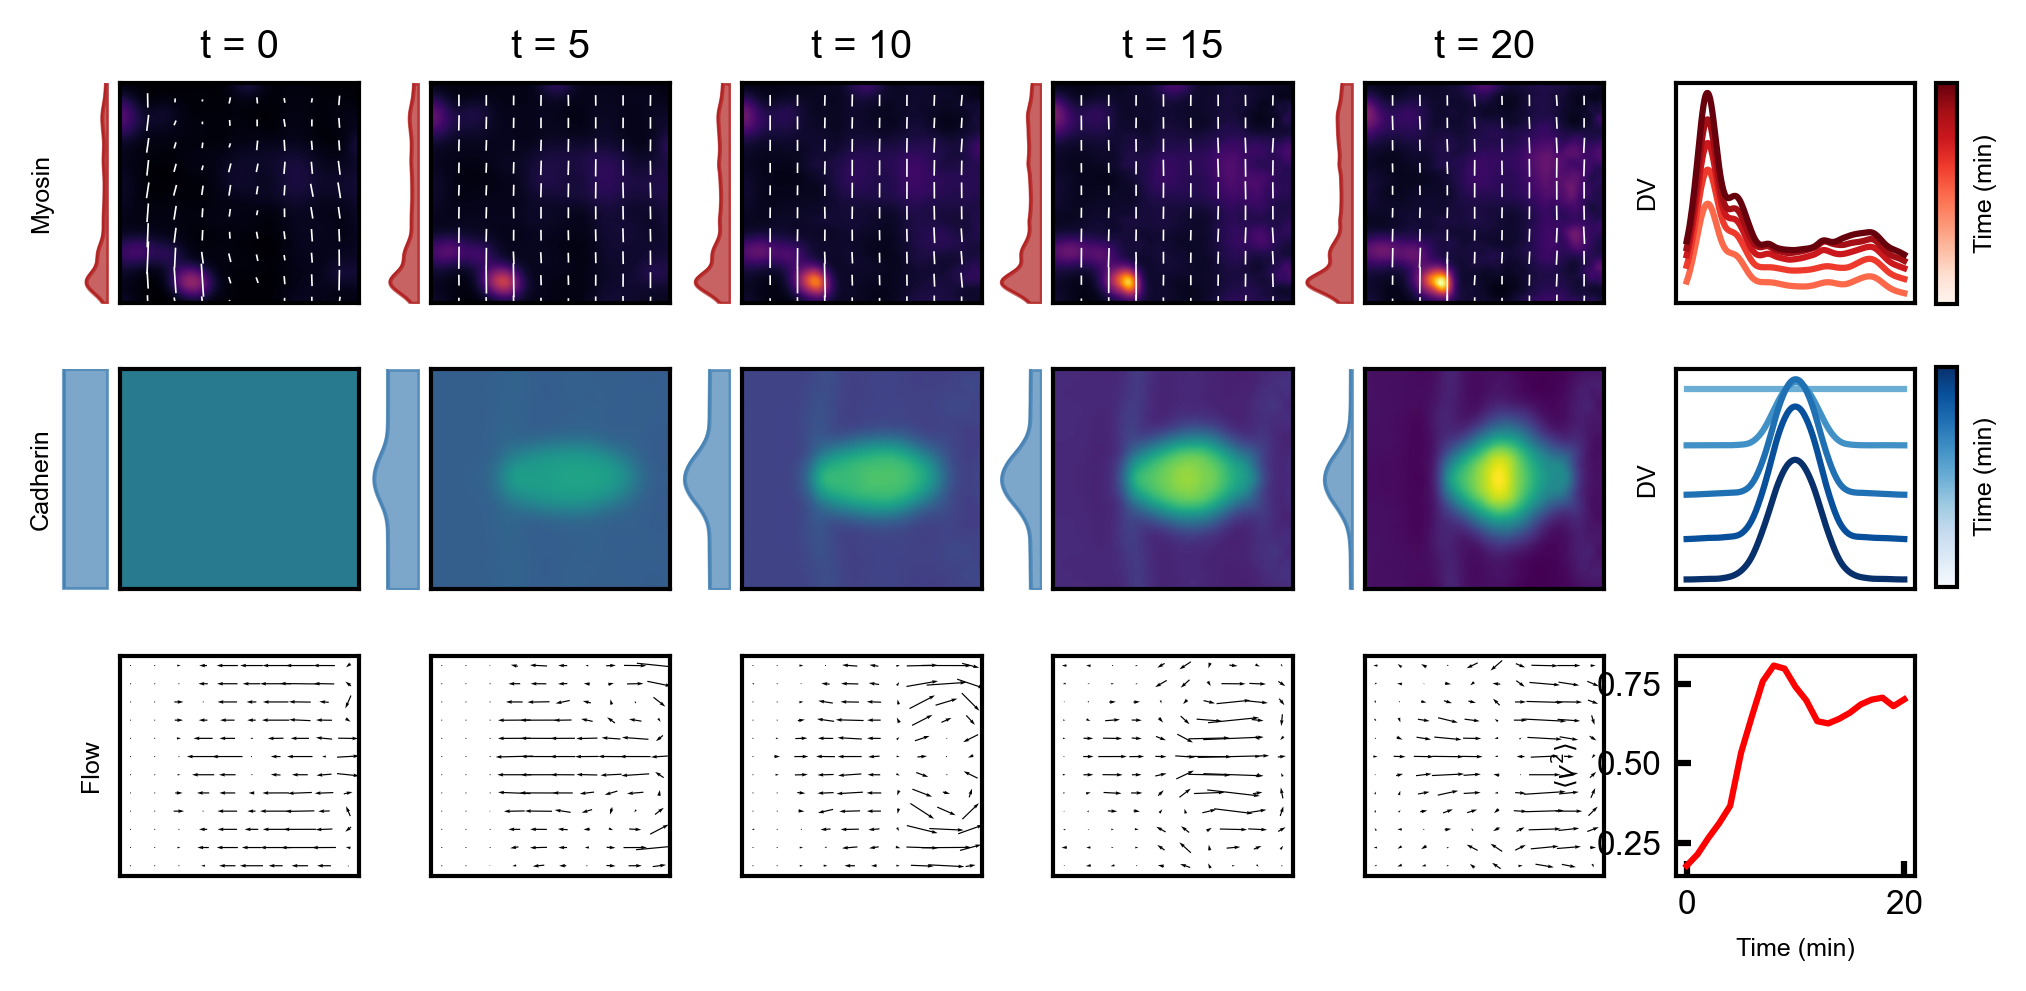

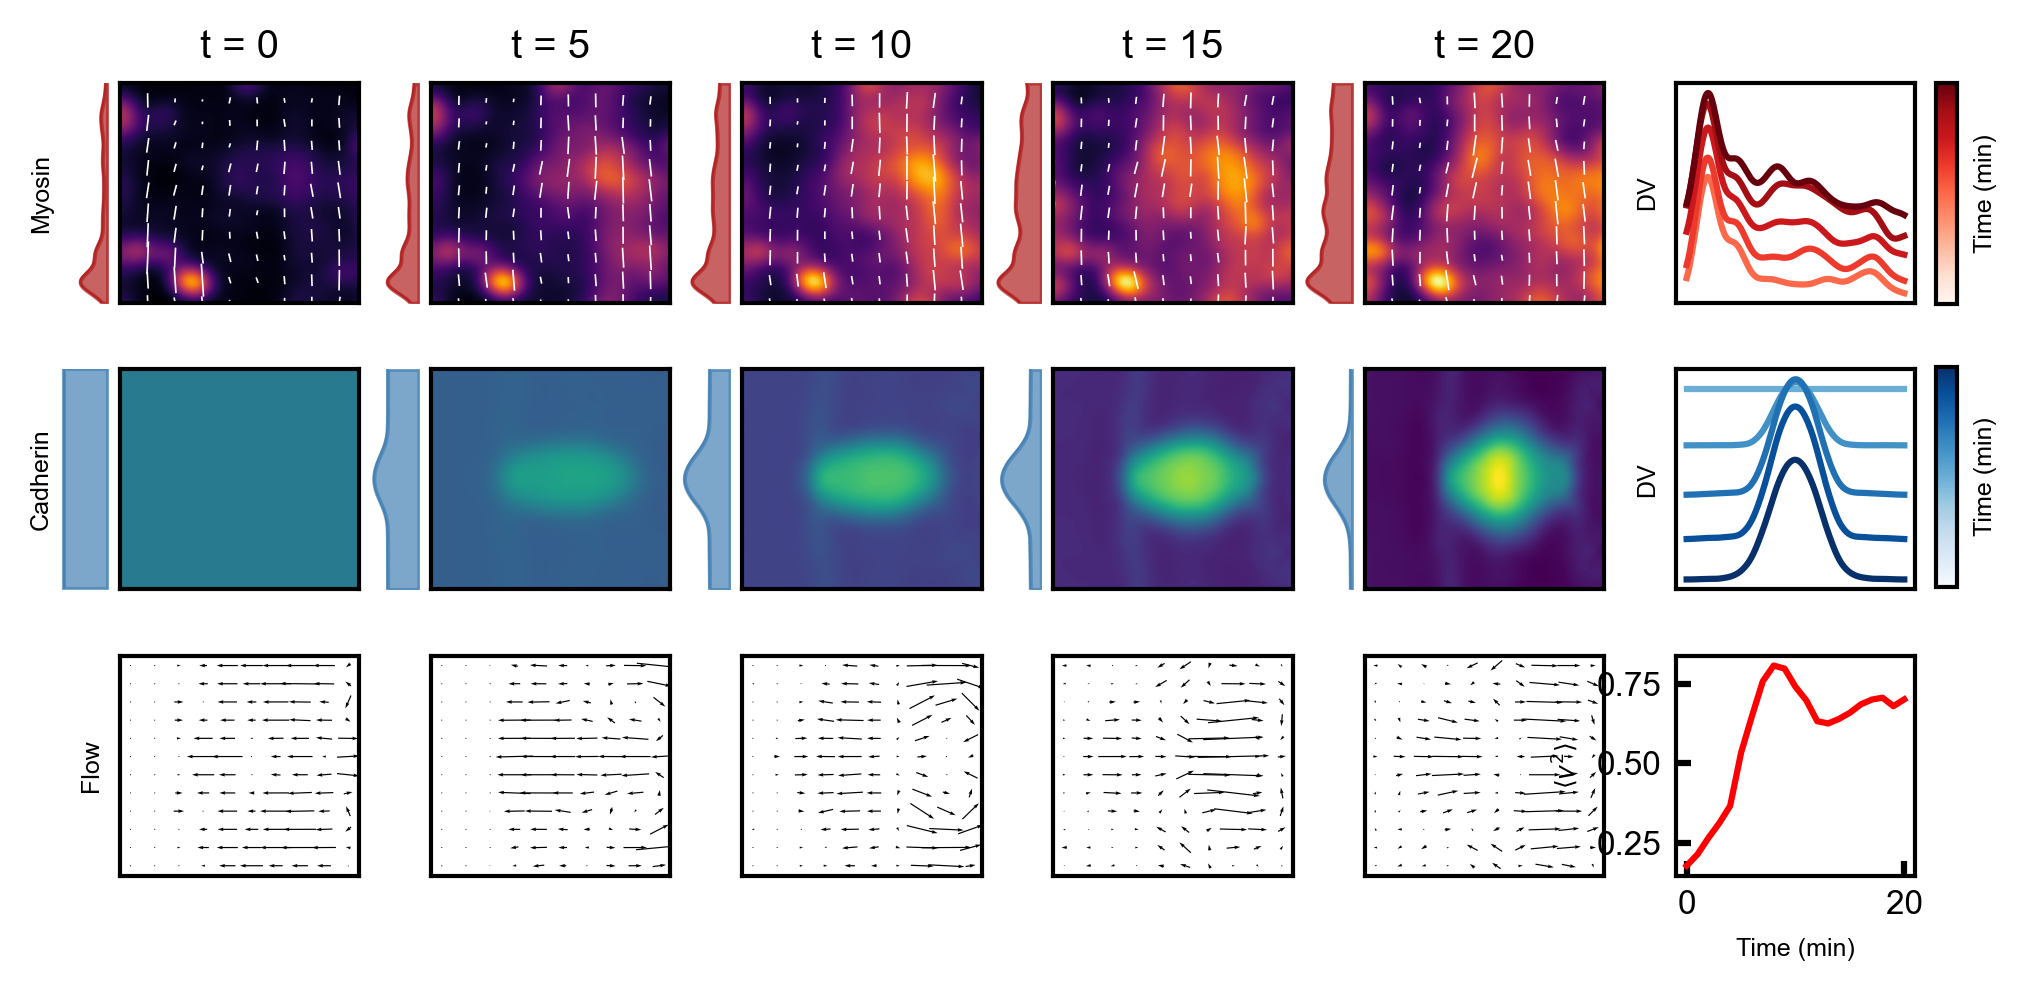

In [184]:

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'

def plot_with_cuts(ax, z, **kwargs):
    try:
        plot_tensor2D(ax, z, **kwargs)
    except:
        color_2D(ax, z, **kwargs)
    
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
        
    N0, N1 = 20, 80
    cut_Y = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
    return cut_Y
    
def plot(m, c, v, t, N=6, mmin=None, mmax=None, cmin=None, cmax=None, mask=None):
    dt = (len(m)-1) // (N-1)

    fig1, ax1 = plt.subplots(3, N+1, figsize=(6+1, 3.5), dpi=300)

    #Boundary crop
    if mask is None:
        mask = np.s_[...]

    if mmin is None:
        mnorm = np.linalg.norm(m[mask], axis=(1, 2))[..., :-20]
        mmin = np.min(mnorm)
        mmax = np.max(mnorm)
    if cmin is None:
        cmin = np.min(c[mask])
        cmax = np.max(c[mask])
        
    cut_cad = []
    cut_sqh = []
    
    for i in range(N):
        ax1[0, i].set_title('t = %d' % (t[dt*i]))

        s1 = plot_with_cuts(ax1[0, i], m[dt*i][mask], 
            cmap='inferno', vmin=mmin, vmax=mmax, both=t[dt*i]<0)    
        c1 = plot_with_cuts(ax1[1, i], c[dt*i][mask],
            cmap='viridis', vmin=cmin, vmax=cmax)
        cut_cad.append(c1)
        cut_sqh.append(s1)
        y = np.linspace(*ax1[0, i].get_ylim(), len(s1))
    
        sqh_color=plt.get_cmap('Reds')((t[dt*i] + 20)/ (np.max(t) + 20))
        cad_color=plt.get_cmap('Blues')((t[dt*i] + 20)/ (np.max(t) + 20))

        ax1[0, -1].plot(y, s1, color=sqh_color)
        ax1[1, -1].plot(y, c1, color=cad_color)

        plot_vector2D(ax1[2, i], v[dt*i], skip=20)
    
    for i in range(N):
        cuts = [cut_sqh[i], cut_cad[i]]
        axes = ax1[:2, i]
        colors = ['firebrick', 'steelblue']
        for cut, ax, color, ax2 in zip(cuts, axes, colors, ax1[:2, -1]):
            y = np.linspace(*ax.get_ylim(), len(cut))

            ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
            ax_Y.plot(cut, y, color=color, lw=0.5)
            ax_Y.fill_betweenx(y, np.ones_like(cut)*ax2.get_ylim()[0], cut,
                               color=color, alpha=0.7)
    
            ax_Y.set(xticks=[], yticks=[])
            ax_Y.set_xlim(ax2.get_ylim())
            ax_Y.invert_xaxis()
            ax_Y.axis('off')
            
    ax1[2, -1].plot(t, np.linalg.norm(v, axis=1).mean(axis=(-2, -1)), color='red')
    ax1[2, -1].set(xlabel='Time (min)', ylabel=r'$\langle v^2 \rangle$')
    ax1[0, -1].set(xticks=[], yticks=[], ylabel='DV')    
    ax1[1, -1].set(xticks=[], yticks=[], ylabel='DV')    

    lp=16
    ax1[0, 0].set_ylabel('Myosin', labelpad=lp)
    ax1[1, 0].set_ylabel('Cadherin', labelpad=lp)
    ax1[2, 0].set_ylabel('Flow')

    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-20, vmax=np.max(t))
    fig1.subplots_adjust(right=0.98, wspace=0.3, hspace=0.3)


    cax = fig1.add_axes([0.99, 0.67, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 cax=cax, label='Time (min)', ticks=[])
    cax = fig1.add_axes([0.99, 0.4, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
                 cax=cax, label='Time (min)', ticks=[])


    for a in ax1.flatten():
        a.set_aspect('auto')

loaddir = 'Public/toll[RM9]/Sqh-GFP/'
#loaddir = 'Public/spaetzle[A]/Sqh-GFP'
df = pd.read_csv(os.path.join(loaddir, 'dynamic_index.csv'))
embryoIDs = df.embryoID.unique()
i = 2
eId = embryoIDs[i]
edir = os.path.join(loaddir, str(eId))

t0 = 15
N = 21
m0 = np.load(os.path.join(edir, 'tensor2D.npy'), mmap_mode='r')[t0:t0+N]
v = np.load(os.path.join(edir, 'velocity2D.npy'), mmap_mode='r')[t0:t0+N]
print(m.shape, v.shape)

with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin = 0
    tmax = 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    gamma_d = data['X_raw/Dorsal_Source'][t_mask, ...]
    gamma_dv = data['X_raw/Static_DV'][0, :, :, 0, 0]    
    c0 = data['fields/c'][t_mask, ...][()]

    
    sigma = 10
    gamma_d = gaussian_filter(gamma_d, sigma=(0, sigma, sigma))
    v = LeftRightSymmetrize().fit_transform(v)
    
    t0 = t[t_mask, ...]
    print(t0.shape)
    
    v_int = interp1d(t0, v, axis=0)
    ds_int = interp1d(t0, gamma_d, axis=0)
    
    mask = np.s_[..., 20:-20, 0:-25]
        
    c0_syn = np.ones(c0[0].shape) * np.mean(c0)

    v = v_int(t0)
    m, c, v, t = integrate(m0[0], c0_syn, v, gamma_d, gamma_dv, t0, dv, ap)
    plot(m, c, v, t, N=5, mask=mask)
    plot(m0, c, v, t, N=5, mask=mask)

# Learning closed loop with just myosin

## Load data

In [3]:
from utils.translation_utils import *
from utils.decomposition_utils import *
from library_generation.extra_functions import *
        
libraries = [
    ('m_ij', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('v', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', None), #Not focused on flow dynamics
]

    
extra_functions = [
    lambda data: material_derivative_terms(data, keys=['m_ij']),
    lambda data: tensor_to_scalar(data, ['E', 'm_ij']),
    lambda data: active_strain_decomposition(data, key='m_ij'),
    lambda data: add_static_sources(data, couple='m_ij'),
    lambda data: add_dorsal_source(data, couple='m_ij', key='ELLIPSE_A=0.5_B=0.25'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_active', 'E_passive']),
    lambda data: remove_terms(data, max_space_order=1),
    lambda data: multiply_tensor_by_scalar(data, None, ['Dorsal_Source']),
]


embryoIDs = None
for key, path, _, _ in libraries:
    with h5py.File(os.path.join(path, 'derivative_library.h5'), 'r') as h5f:
        eIds = list(h5f.keys())
        if embryoIDs is None:
            embryoIDs = set(eIds)
        else:
            embryoIDs = embryoIDs.union(eIds)
embryoIDs = list(embryoIDs)
with h5py.File('Public/myosin_dynamics_fitting.h5', 'w') as data:
    for embryoID in embryoIDs:
        print(embryoID)
        group, feature_names = fill_group_info(data, embryoID, libraries)
        collect_library(group, 
                        libraries, 
                        feature_names, 
                        extra_functions=extra_functions)
        decompose_library(group, libraries, window_length=9)
        print('DONE')

202007081130
Added /202007081130 to m_ij library
Added /202007081130 to v library
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
DONE
202007011145
Added /202007011145 to m_ij library
Added /202007011145 to v library
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
DONE
202009041145
Added /202009041145 to m_ij library
Added /202009041145 to v library
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
DONE
202007091200
Added /202007091200 to m_ij library
Added /202007091200 to v library
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
DONE
ensemble
Added /ensemble to m_ij library
Added /ensemble to v library
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
DONE
202006261115
Added /202006261115 to m_ij library
Added /202006261115 to v library
Decomposing library for m_ij
C

## Learn Myosin model

[0.675 0.829 0.906 0.936 0.952 0.96  0.966 0.972 0.976 0.98  0.982 0.984
 0.986 0.988 0.989 0.99 ]
Using only overleaf-allowed terms
Skipping ensemble average from fit!
Adding Material Derivative terms to LHS
Applying train/test split
Using an ensemble optimizer!
D_t m_ij  = -0.008 m_ij + 1.378 m_ij Tr(E_passive) + 0.013 Static_DV Tr(m_ij) + 0.194 m_ij Tr(m_ij) + 0.075 Dorsal_Source m_ij + -1.212 Dorsal_Source m_ij Tr(E_passive) + -0.004 Dorsal_Source Static_DV + -0.525 Dorsal_Source m_ij Tr(m_ij)
PCA Component R2=-0.687941	MSE=0.241074


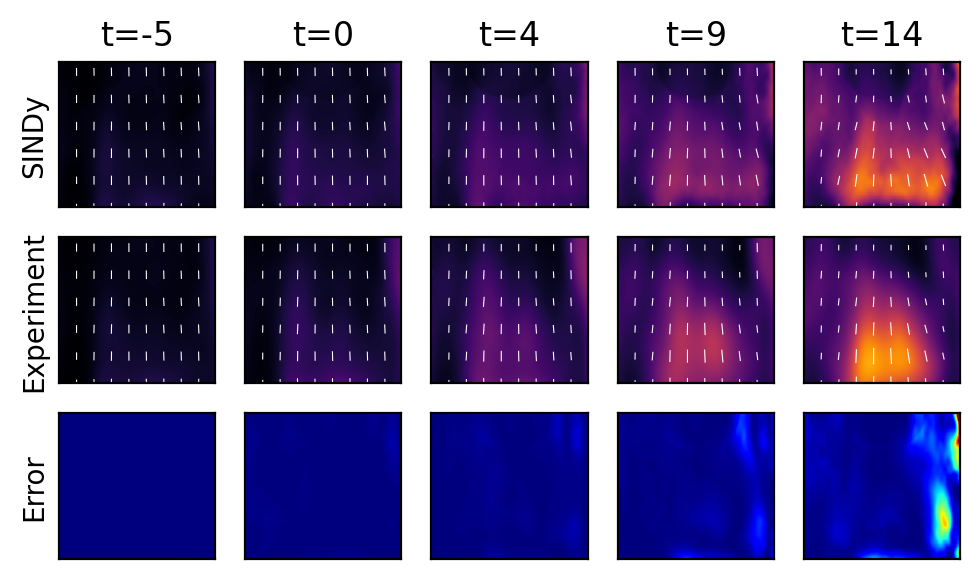

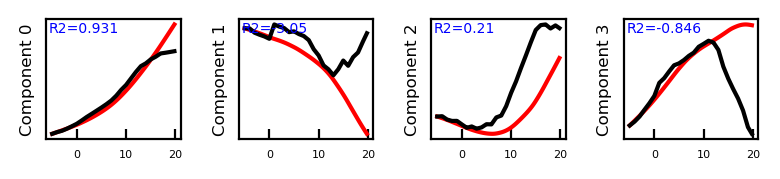

In [22]:
from utils.translation_utils import *

lib_path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP'
lib_key = 'm_ij'
plt.rcParams['figure.dpi'] = 200
np.set_printoptions(precision=3, suppress=True)

with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'tensor_SVDPipeline_PMG_CF.pkl'), 'rb'))

    evr = model['svd'].explained_variance_ratio_
    print(np.cumsum(evr))
    keep=np.cumsum(evr) <= 0.95
    scaled_evr = evr / np.min(evr[keep]) * keep
    
    info = dict(
        key=lib_key,
        tmin=-5, tmax=10,
        material_derivative=True,
        keep=keep,
        threshold=0,
        alpha=1e-3,
        n_candidates_to_drop=0,
        n_models=10,
        n_subset=1000,
        overleaf_only=True,
        #component_weight=scaled_evr**2,
        collect_function=collect_raw_data,
        component_weight=None,
    )
    sindy = fit_sindy_model(h5f, **info)

    data = h5f['ensemble']
    
    '''
    Evaluate model
    '''
    tmin, tmax = info['tmin'], info['tmax']
    tmin, tmax = -5, 20
    
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models/tensor_SVDPipeline.pkl'), 'rb'))
    evr = model['svd'].explained_variance_ratio_
    
    keep = np.cumsum(evr) <= 1
    tmin = max(tmin, int(np.min(data['fields'][lib_key].attrs['t'])))
    tmax = min(tmax, int(np.max(data['fields'][lib_key].attrs['t'])))
    pred, interp, times = sindy_predict(data, lib_key, sindy, model, keep, tmin=tmin, tmax=tmax)
    plt.rcParams['image.cmap'] = 'inferno'
    sindy_predictions_plot(pred, interp, model, times, keep, data)
    decomposed_predictions_plot(pred, interp, model, times, info['keep'])


## Load geometric information

In [19]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.interpolate import interpn, RectBivariateSpline
from scipy.io import loadmat
from utils.decomposition_utils import *


with h5py.File('Public/raw_dynamics_fitting.h5', 'r') as h5f:
    ap = h5f['ensemble/links/m_ij/AP_coordinates'][0, :][()]
    dv = h5f['ensemble/links/m_ij/DV_coordinates'][:, 0][()]
    dAP = ap[1]-ap[0]
    dDV = dv[1]-dv[0]
    YX = np.stack(np.meshgrid(dv, ap, indexing='ij'), axis=-1)

geo_dir = '../flydrive.synology.me/Public/dynamic_atlas/embryo_geometry'
geometry = loadmat(os.path.join(geo_dir, 'embryo_rectPIVscale_fundamentalForms.mat'), simplify_cells=True)
#Convert to microns
X0g = geometry['X0'][0, :] * 0.2619 / 0.4
Y0g = geometry['Y0'][:, 0] * 0.2619 / 0.4
print('Metric Extent: %.3f %.3f %.3f %.3f' % (
    X0g.min(), X0g.max(), Y0g.min(), Y0g.max()))
print('Data Extent: %.3f %.3f %.3f %.3f' % (
    ap.min(), ap.max(), dv.min(), dv.max()))

Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
print('Loaded Christoffel symbols from Public')

def embryo_pad(x0, pad_width=20, dv_pad='wrap', ap_pad='edge', **kwargs):
    x = x0.reshape([-1, *x0.shape[-2:]])
    x = np.pad(x, ((0, 0), (pad_width, pad_width), (0, 0)), mode=dv_pad)
    x = np.pad(x,  ((0, 0), (0, 0), (pad_width, pad_width)), mode=ap_pad)
    x = x.reshape([*x0.shape[:-2], *x.shape[-2:]])
    '''
    Since we reflected along the x axis, we have to 
    adjust vector/tensor components in the reflected region
    '''
    if ap_pad in ['reflect', 'symmetric']:
        if len(x.shape) == 3: #Vector
            x[1, :,  :pad_width] *= -1
            x[1, :, -pad_width:] *= -1

        elif len(x.shape) == 4: #Tensor
            x[0, 1, :,  :pad_width] *= -1
            x[0, 1, :, -pad_width:] *= -1
            x[1, 0, :,  :pad_width] *= -1
            x[1, 0, :, -pad_width:] *= -1
    return x

def gradient(x0, dDV=2.7, dAP=2.7, sigma=5, **pad_kwargs):
    pad_width=4*sigma
    x = embryo_pad(x0, pad_width=pad_width, **pad_kwargs)

    dY_x = gaussian_filter1d(x, axis=-2, sigma=sigma, order=1, mode='nearest') / dDV
    dX_x = gaussian_filter1d(x, axis=-1, sigma=sigma, order=1, mode='nearest') / dAP
    return np.stack([
        dY_x[..., pad_width:-pad_width, pad_width:-pad_width],
        dX_x[..., pad_width:-pad_width, pad_width:-pad_width]
    ], axis=-1)

def covariant_gradient(x0, **diff_args):
    grad_x = gradient(x0, **diff_args)

    if len(x0.shape) == 3: #Vector
        grad_x += np.einsum('yxijk,kyx->iyxj', Gijk, x0)
        #grad_x -= np.einsum('yxkij,kyx->iyxj', Gijk, x0)
    elif len(x0.shape) == 4: #Tensor
        grad_x += np.einsum('yxikl,ljyx->ijyxk', Gijk, x0) + \
                  np.einsum('yxjkl,ilyx->ijyxk', Gijk, x0)
        #grad_x -= np.einsum('yxlik,ljyx->ijyxk', Gijk, x0) + \
        #          np.einsum('yxljk,ilyx->ijyxk', Gijk, x0)
    return grad_x

Metric Extent: 4.911 446.867 4.911 525.437
Data Extent: 3.230 455.701 3.227 536.891
Loaded Christoffel symbols from Public


## Run integration

Integration status:  0 The solver successfully reached the end of the integration interval.


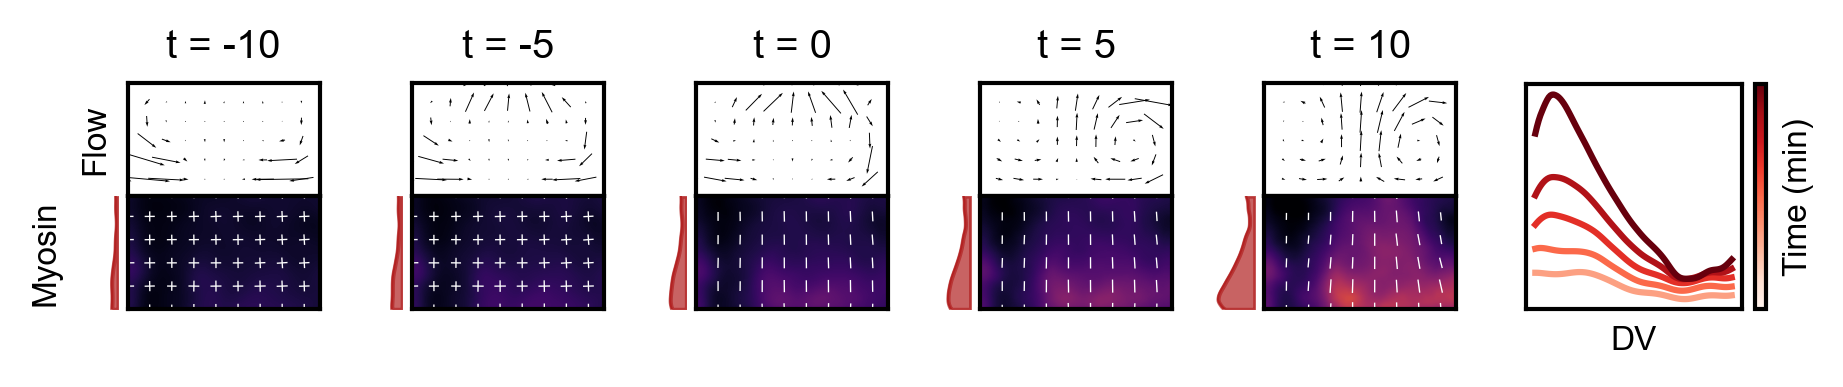

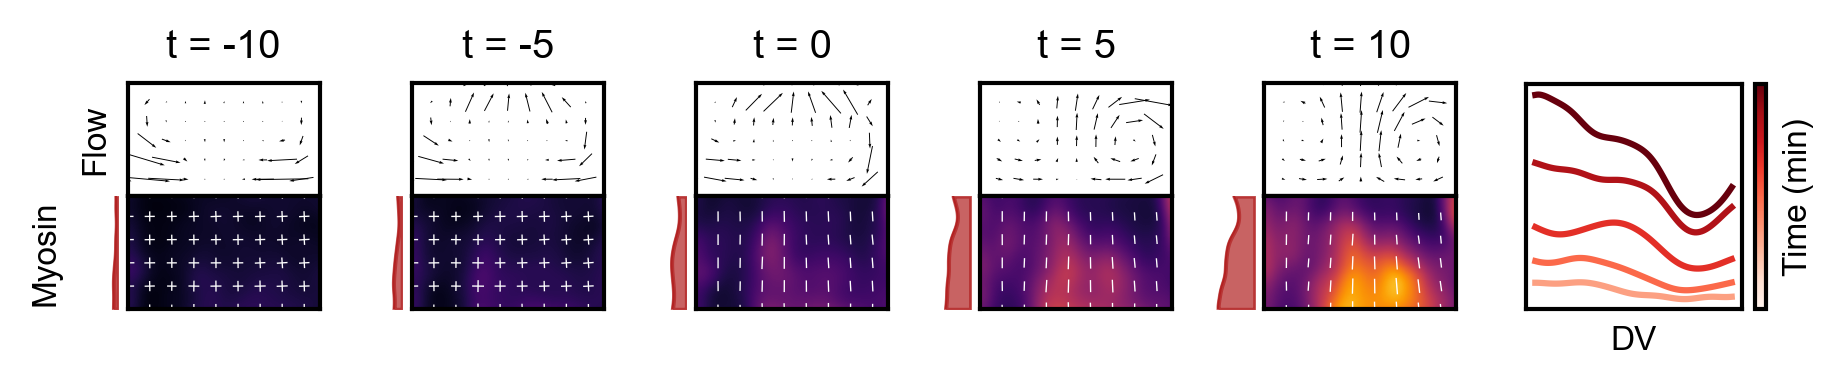

In [115]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'


def plot_with_cuts(ax, z, **kwargs):
    plot_tensor2D(ax, z, **kwargs)
    
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
        
    N0, N1 = 20, 80
    cut_Y = np.sum(znorm[:118, N0:N1], axis=1) / np.sum(base[:118, N0:N1], axis=1)
    return cut_Y
    
def plot(m, v, t, N=5, mmin=None, mmax=None, cmin=None, cmax=None, mask=None):
    dynamic_mask = np.load('Public/Masks/Dynamic_PMG_CF_mask.npy', mmap_mode='r')
    dynamic_time = np.load('Public/Masks/Dynamic_PMG_CF_time.npy', mmap_mode='r')
    msk = interp1d(dynamic_time, dynamic_mask, axis=0, fill_value='extrapolate')

    dt = (len(m)-1) // (N-1)

    fig, ax = plt.subplots(2, N, figsize=(N+1, 1), dpi=300)
    fig.subplots_adjust(hspace=0, wspace=0.1)
    ax_cut = fig.add_axes([.92, 0.125, .75/N, 0.75])

    #Boundary crop
    if mask is None:
        mask = np.s_[...]

    if mmin is None:
        mnorm = np.linalg.norm(m[mask], axis=(1, 2))[..., :-20]
        mmin = np.min(mnorm)
        mmax = np.max(mnorm)
        
    cut_sqh = []
    offset = 20
    for i in range(N):
        ax[0, i].set_title('t = %d' % (t[dt*i]))
        vi = v[dt*i].copy()
        vi[0] *= -1
        plot_vector2D(ax[0, i], vi, skip=20)
        ax[0, i].invert_yaxis()
        
        alpha = msk(t[dt*i]).astype(float)[mask]
        alpha[alpha == 0] = 1

        s1 = plot_with_cuts(ax[1, i], m[dt*i][mask], 
            cmap='inferno', vmin=mmin, vmax=mmax, both=t[dt*i]<0, alpha=alpha)    
        cut_sqh.append(s1)
        
        y = np.linspace(*ax[1, i].get_ylim(), len(s1))
        sqh_color=plt.get_cmap('Reds')((t[dt*i] + offset)/ (np.max(t) + offset))
        ax_cut.plot(y, s1, color=sqh_color)
    
    for i in range(N):
        cut = cut_sqh[i]
        color = 'firebrick'
        y = np.linspace(*ax[1, i].get_ylim(), len(cut))

        ax_Y = ax[1, i].inset_axes([-0.25, 0, 0.2, 1], sharey=ax[1, i])
        ax_Y.plot(cut, y, color=color, lw=0.5)
        ax_Y.fill_betweenx(y, np.ones_like(cut)*ax_cut.get_ylim()[0], cut,
                           color=color, alpha=0.7)

        ax_Y.set(xticks=[], yticks=[])
        ax_Y.set_xlim(ax_cut.get_ylim())
        ax_Y.invert_xaxis()
        ax_Y.axis('off')
            
    ax_cut.set(xticks=[], yticks=[], xlabel='DV')    

    lp=16
    ax[1, 0].set_ylabel('Myosin', labelpad=lp)
    ax[0, 0].set_ylabel('Flow')

    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-20, vmax=np.max(t))
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 ax=ax_cut, label='Time (min)', ticks=[])


def rhs(t, y, v_int, diff_args, nDV=236, nAP=200):
    m = y.reshape([2, 2, nDV, nAP])

    d1_m = covariant_gradient(m, **diff_args)
    v = v_int(t)
    d1_v = covariant_gradient(v, **diff_args)

    O = -0.5 * (np.einsum('iyxj->ijyx', d1_v) - np.einsum('jyxi->ijyx', d1_v))
    E = 0.5 * (np.einsum('iyxj->ijyx', d1_v) + np.einsum('jyxi->ijyx', d1_v))

    deviatoric = m - 0.5 * np.einsum('kkyx,ij->ijyx', m, np.eye(2))

    m_0 = np.linalg.norm(m, axis=(0, 1), keepdims=True).mean(axis=(2, 3), keepdims=True)
    dev_mag = np.linalg.norm(deviatoric, axis=(0, 1), keepdims=True)

    devE = np.einsum('klyx,klyx->yx', deviatoric, E)[None, None]

    E_active = E - np.sign(devE) * devE * deviatoric / dev_mag**2
    E_active = 0.5 * E_active * dev_mag / m_0 
    E_passive = E - E_active

    mE = np.einsum('ikyx,kjyx->ijyx', m, E_passive) + np.einsum('ikyx,kjyx->ijyx', E_passive, m) 

    dv = gamma_dv[:, :, None, None]
    trm = np.einsum('kkyx->yx', m)[None, None]
    trE = np.einsum('kyxk->yx', d1_v)

    #D_t m_ij  = -0.062 m_ij + 0.033 Static_DV Tr(m_ij) + 0.429 m_ij Tr(m_ij)
    #D_t m_ij  = -0.058 m_ij + -0.058 {m_ij, E_passive} + 0.031 Static_DV Tr(m_ij) + 0.416 m_ij Tr(m_ij)
    mdot =  -1.000 * np.einsum('kyx,ijyxk->ijyx', v, d1_m)
    mdot -= +1.000 * np.einsum('ikyx,kjyx->ijyx', O, m)
    mdot -= -1.000 * np.einsum('ikyx,kjyx->ijyx', m, O)
    mdot += -0.058 * m
    mdot +=  .75 * mE
    mdot +=  0.031 * trm * dv
    mdot +=  0.416 * trm * m

    return mdot.flatten()
    
def integrate(m0, v0, gamma_dv, t, YY, XX, t_eval=None):
    '''
    Integrate two fields m, c according to SINDy-identified equations
    Include a co-evolving velocity field and two source fields
    ''' 
    #Set up interpolators for control fields
    v_int = interp1d(t, v0, axis=0)
    
    #Set up differentiators
    nDV = YY.shape[0]
    nAP = XX.shape[0]
        
    dAP = XX[1] - XX[0]
    dDV = YY[1] - YY[0]
    diff_args = dict(
        dAP=dAP,
        dDV=dDV,
        sigma=3, 
    )
    
    y0 = m0.flatten()
    if t_eval is None:
        t_eval = t
    out = solve_ivp(rhs, [t[0], t[-1]], y0, t_eval=t_eval, 
                    args=(v_int, diff_args, nDV, nAP))
    print('Integration status: ', out['status'], out['message'])
    m = out['y'].T.reshape([-1, 2, 2, nDV, nAP])
    v = v_int(t_eval)
    
    return m, v, out['t']

from utils.decomposition_utils import LeftRightSymmetrize
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin = -10
    tmax = 10
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    t0 = t[t_mask, ...]
    
    m0 = data['fields/m_ij'][t_mask, ...][()]
    v = data['fields/v'][t_mask, ...][()]    
    v = LeftRightSymmetrize().fit_transform(v)    
    v_int = interp1d(t0, v, axis=0)
    gamma_dv = np.array([[1., 0], [0, 0]])
    
    m, v, t = integrate(m0[0], v, gamma_dv, t0, dv, ap)
    
    mnorm = np.linalg.norm(m0, axis=(1, 2))
    mmin = np.min(mnorm)
    mmax = np.max(mnorm)
    
    mask = np.s_[..., 20:-20, 0:-25]
    plot(m, v, t, N=5, mmin=mmin, mmax=mmax, mask=mask)
    plot(m0, v, t, N=5, mmin=mmin, mmax=mmax, mask=mask)

# Learning closed loop with myosin and cadherin

## Load data

In [239]:
from utils.translation_utils import *
from utils.decomposition_utils import *
from library_generation.extra_functions import *
        
libraries = [
    #('c', 'Public/WT/ECad-GFP', 'scalar_library', 'cyt_SVDPipeline_PMG_CF.pkl'), 
    ('c', 'Public/WT/ECad-GFP', 'scalar_library', 'raw_SVDPipeline_PMG_CF.pkl'), 
    ('m_ij', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('v', 'Public/WT/ECad-GFP', 'tensor_library', None), #Not focused on flow dynamics
    ('v', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', None), #Not focused on flow dynamics
]

    
extra_functions = [
    lambda data: material_derivative_terms(data, keys=['m_ij', 'c']),
    lambda data: tensor_to_scalar(data, ['E', 'm_ij']),
    lambda data: scalar_couple(data, ['c', 'Tr(E)', 'Tr(m_ij)']),
    lambda data: active_strain_decomposition(data, key='m_ij'),
    lambda data: add_static_sources(data, couple='m_ij'),
    lambda data: add_dorsal_source(data, couple='c', key='CIRCLE_R=0.2'),
    lambda data: add_constant_source(data, 'c'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_active', 'E_passive']),
    lambda data: remove_terms(data, max_space_order=1),
    lambda data: multiply_tensor_by_scalar(data, None, ['c']),
]


embryoIDs = None
for key, path, _, _ in libraries:
    with h5py.File(os.path.join(path, 'derivative_library.h5'), 'r') as h5f:
        eIds = list(h5f.keys())
        if embryoIDs is None:
            embryoIDs = set(eIds)
        else:
            embryoIDs = embryoIDs.union(eIds)
embryoIDs = list(embryoIDs)
#embryoIDs = ['ensemble']
#embryoIDs = ['202001280915']
with h5py.File('Public/raw_dynamics_fitting.h5', 'w') as data:
    for embryoID in embryoIDs:
        print(embryoID)
        group, feature_names = fill_group_info(data, embryoID, libraries)
        collect_library(group, 
                        libraries, 
                        feature_names, 
                        extra_functions=extra_functions)
        decompose_library(group, libraries, window_length=9)
        print('DONE')

202007081130
Added ensemble to c library
Added /202007081130 to m_ij library
Added ensemble to v library
Added /202007081130 to v library
Not computing dynamics for c
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
Not computing dynamics for v
DONE
202007011145
Added ensemble to c library
Added /202007011145 to m_ij library
Added ensemble to v library
Added /202007011145 to v library
Not computing dynamics for c
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
Not computing dynamics for v
DONE
202007091200
Added ensemble to c library
Added /202007091200 to m_ij library
Added ensemble to v library
Added /202007091200 to v library
Not computing dynamics for c
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
Not computing dynamics for v
DONE
202008131005
Added ensemble to c library
Added /202008131005 to m_ij library
Added ensemble to v library
Added /202008

## Cadherin

Skipping ensemble average from fit!
Adding Material Derivative terms to LHS
Applying train/test split
Using an ensemble optimizer!
D_t c  = 0.000


/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients


PCA Component R2=-9.28496	MSE=0.189529


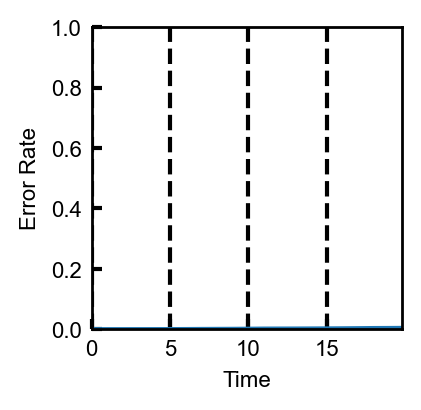

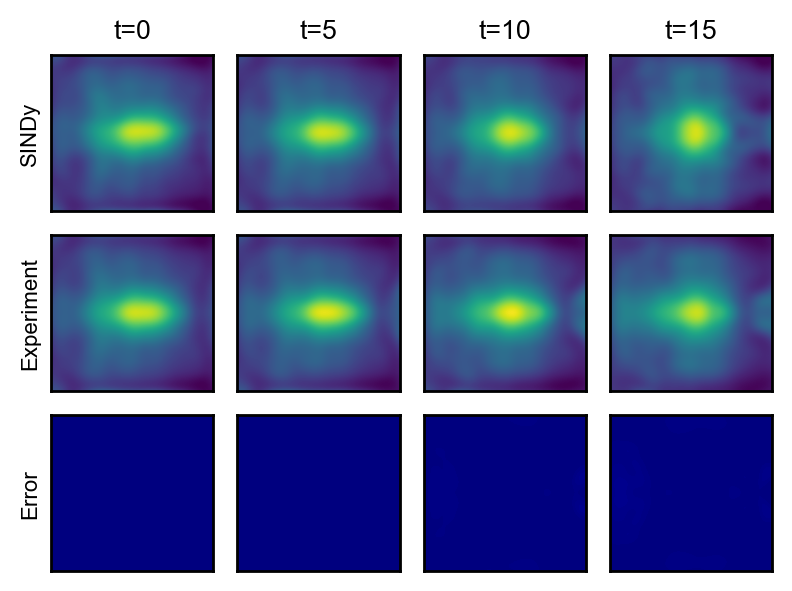

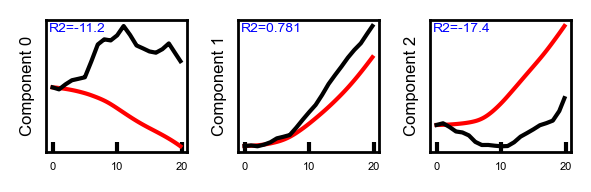

In [8]:
from utils.translation_utils import *

lib_path = 'Public/WT/ECad-GFP'
lib_key = 'c'

plt.rcParams['figure.dpi'] = 200

with h5py.File('Public/raw_dynamics_fitting.h5', 'r') as h5f:
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'raw_SVDPipeline_PMG_CF.pkl'), 'rb'))
    #model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'raw_SVDPipeline.pkl'), 'rb'))

    evr = model['svd'].explained_variance_ratio_
    keep=np.cumsum(evr) <= 0.93
    scaled_evr = evr / np.min(evr[keep]) * keep
    
    info_ovl = dict(
        key=lib_key,
        tmin=0, tmax=15,
        scale_units=True,
        material_derivative=True,
        #component_weight=scaled_evr**2,
        threshold=0,
        alpha=0,#1e0,
        n_candidates_to_drop=0,
        n_models=10,
        n_subset=30,
        overleaf_only=True,
        collect_function=collect_raw_data,
        component_weight=None,
    )
    info_all = dict(
        key=lib_key,
        tmin=-5, tmax=15,
        scale_units=True,
        material_derivative=True,
        threshold=1e-2,
        alpha=1e2,
        n_candidates_to_drop=1,
        n_models=10,
        n_subset=30,
        overleaf_only=False,
        #collect_function=collect_raw_data,
        #component_weight=None,
        component_weight=scaled_evr,
    )
    info = info_all
    sindy = fit_sindy_model(h5f, **info)

    data = h5f['ensemble']
    '''
    Evaluate model
    '''
    tmin, tmax = info['tmin'], info['tmax']
    tmin, tmax = 0, 20
    
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models/raw_SVDPipeline.pkl'), 'rb'))
    evr = model['svd'].explained_variance_ratio_
    
    keep = np.cumsum(evr) <= 1
    tmin = max(tmin, int(np.min(data['fields'][lib_key].attrs['t'])))
    tmax = min(tmax, int(np.max(data['fields'][lib_key].attrs['t'])))
    pred, interp, times = sindy_predict(data, lib_key, sindy, model, keep, tmin=tmin, tmax=tmax)
    plt.rcParams['image.cmap'] = 'viridis'
    plt.rcParams['font.size'] = 8
    sindy_predictions_plot(pred, interp, model, times, keep, data, plot_fn=color_2D)
    decomposed_predictions_plot(pred, interp, model, times, scaled_evr > 0)

## Myosin

[0.569 0.771 0.876 0.914 0.934 0.948 0.956 0.963 0.967 0.971 0.974 0.977
 0.98  0.981 0.983 0.984]
Using only overleaf-allowed terms
Skipping ensemble average from fit!
Adding Material Derivative terms to LHS
Applying train/test split
Using an ensemble optimizer!
D_t m_ij  = -0.007 m_ij + -0.668 {m_ij, E_passive} + 1.072 c {m_ij, E_passive} + 0.007 Static_DV Tr(m_ij) + 0.209 m_ij Tr(m_ij)
PCA Component R2=-0.87454	MSE=0.344385


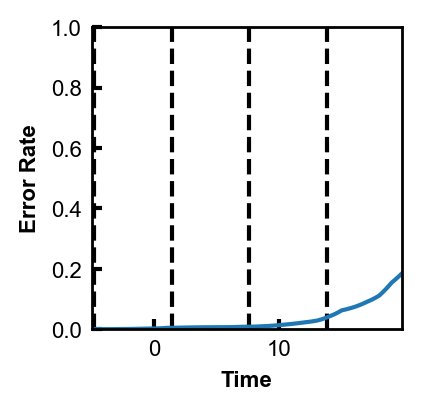

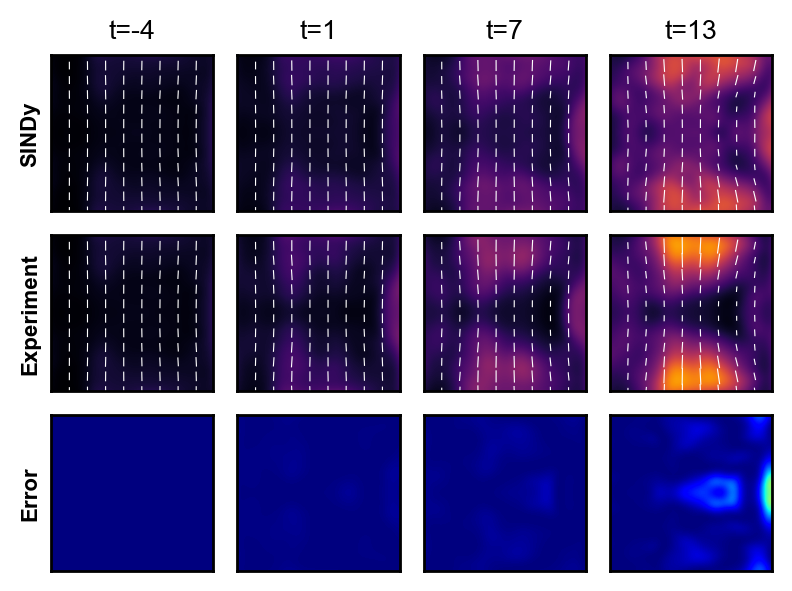

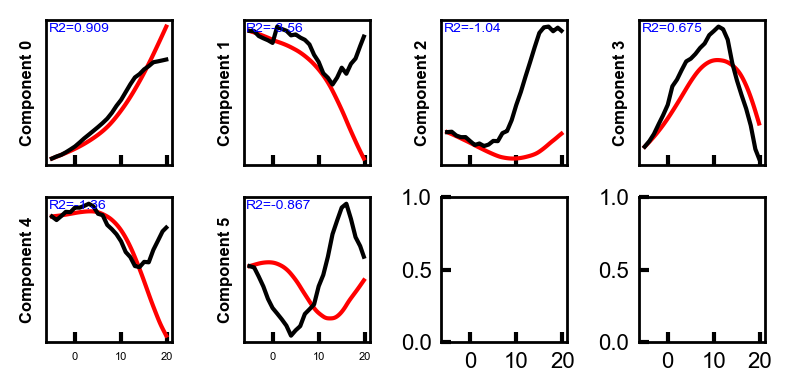

In [255]:
from utils.translation_utils import *

lib_path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP'
lib_key = 'm_ij'
plt.rcParams['figure.dpi'] = 200
np.set_printoptions(precision=3, suppress=True)

with h5py.File('Public/raw_dynamics_fitting.h5', 'r') as h5f:
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'tensor_SVDPipeline.pkl'), 'rb'))
    #model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'tensor_SVDPipeline_PMG_CF.pkl'), 'rb'))

    evr = model['svd'].explained_variance_ratio_
    print(np.cumsum(evr))
    keep=np.cumsum(evr) <= 0.95
    scaled_evr = evr / np.min(evr[keep]) * keep
    
    info_ovl = dict(
        key=lib_key,
        tmin=-5, tmax=10,
        material_derivative=True,
        keep=keep,
        #component_weight=scaled_evr**2,
        threshold=0,
        alpha=1e-1,
        n_candidates_to_drop=0,
        n_models=10,
        n_subset=1000,
        overleaf_only=True,
        collect_function=collect_raw_data,
        component_weight=None,
    )
    info = info_ovl
    sindy = fit_sindy_model(h5f, **info)

    data = h5f['ensemble']
    #data = h5f['202001280915']
    #data = h5f['202001282000']
    
    '''
    Evaluate model
    '''
    tmin, tmax = info['tmin'], info['tmax']
    tmin, tmax = -5, 20
    
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models/tensor_SVDPipeline.pkl'), 'rb'))
    evr = model['svd'].explained_variance_ratio_
    
    keep = np.cumsum(evr) <= 1
    tmin = max(tmin, int(np.min(data['fields'][lib_key].attrs['t'])))
    tmax = min(tmax, int(np.max(data['fields'][lib_key].attrs['t'])))
    pred, interp, times = sindy_predict(data, lib_key, sindy, model, keep, tmin=tmin, tmax=tmax)
    plt.rcParams['image.cmap'] = 'inferno'
    sindy_predictions_plot(pred, interp, model, times, keep, data)
    decomposed_predictions_plot(pred, interp, model, times, info['keep'])


## Ensembling

In [253]:
%%capture --no-display

from utils.translation_utils import *
from itertools import product

lib_path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP'
lib_key = 'm_ij'
plt.rcParams['figure.dpi'] = 200
np.set_printoptions(precision=3, suppress=True)

model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 
                                  'tensor_SVDPipeline.pkl'), 'rb'))
                                  #'tensor_SVDPipeline_PMG_CF.pkl'), 'rb'))


sindy_results = pd.DataFrame()

evr = model['svd'].explained_variance_ratio_
keep=np.cumsum(evr) <= 0.95
scaled_evr = evr / np.min(evr[keep]) * keep


withold_0 = []
withold_1 = ['E_passive', 'c E_passive', 'c m_ij', 'E_passive Tr(m_ij)', 'c m_ij Tr(E_passive)', 'c E_passive Tr(m_ij)', 'Static_DV', 'c Static_DV', 'c {m_ij, Static_DV}']

withold = withold_0# + withold_1

info = dict(
    key=lib_key,
    tmin=-10, tmax=20,
    material_derivative=True,
    component_weight=scaled_evr,
    n_models=10,
    n_candidates_to_drop=5,
    n_subset=30,
    overleaf_only=False,
    withold=withold
)

alphas = np.geomspace(1e-1, 5e1, 5)
thresholds = np.geomspace(1e-3, 5e-2, 5)
ntrials = 5

with h5py.File('Public/raw_dynamics_fitting.h5', 'r') as h5f:
    '''
    ntrials = 25
    for alpha in alphas:
        for i in range(ntrials):
            info['alpha'] = alpha
            sindy = fit_ssr_model(h5f, **info)
            coef_list = np.array(sindy.optimizer.history_).squeeze()
            score_list = np.array(sindy.optimizer.err_history_).squeeze()
            #SINDy doesn't record error for initial guess
            score_list = np.concatenate([[score_list[0]], score_list]) 
            
            df = pd.DataFrame(coef_list, columns=sindy.feature_names)
            df['score'] = score_list
            sindy_results = sindy_results.append(df, ignore_index=True).fillna(value=0)
    '''
    
    ntrials = 5
    for alpha, threshold in product(alphas, thresholds):
        for i in range(ntrials):
            info['alpha'] = alpha
            info['threshold'] = threshold
            sindy = fit_sindy_model(h5f, **info)
            
            fn = sindy.feature_names
            coef_list = np.array(sindy.coef_list_).squeeze() #n_models x n_coefs
            coef = sindy.coefficients().squeeze()
            reg = np.nan_to_num(coef / np.median(coef_list, axis=0))
            coef_list *= reg

            mses_list = np.array(sindy.mses_list_).squeeze() #n_models x n_cpts
            weighted_mse = np.average(mses_list, axis=-1, weights=scaled_evr) * 1000

            df = pd.DataFrame(coef_list, columns=fn)
            df['score'] = weighted_mse
            sindy_results = sindy_results.append(df, ignore_index=True)
sindy_results

,E_passive,E_passive Tr(m_ij),Static_DV,Static_DV Tr(m_ij),c E_passive,c E_passive Tr(m_ij),c Static_DV,c Static_DV Tr(m_ij),c m_ij,c m_ij Tr(E_passive),c m_ij Tr(m_ij),"c {m_ij, E_passive}","c {m_ij, Static_DV}",m_ij,m_ij Tr(E_passive),m_ij Tr(m_ij),"{m_ij, E_passive}","{m_ij, Static_DV}",score
0,0.0,0.0,0.0,-0.000000,0.247200,1.999230,0.0,-0.000000,0.405655,0.0,0.0,0.0,-0.000000,-1.139067,2.081798,0.080708,-6.687320,0.0,17.726581
1,0.0,-0.0,0.0,-44.788103,0.000000,-0.278977,-0.0,1.117193,0.050804,0.0,0.0,0.0,0.009167,0.441526,0.000000,0.066946,3.912008,0.0,17.987256
2,0.0,0.0,-0.0,-33.643506,0.290012,3.964221,0.0,-45.219399,1.018247,0.0,0.0,-0.0,-0.000000,-2.143721,4.195445,-0.000000,-17.189691,0.0,14.893169
3,-0.0,0.0,0.0,-0.000000,0.108166,2.969481,-0.0,-0.735293,0.413448,0.0,0.0,0.0,-0.010317,0.598209,0.057132,0.089583,6.409788,0.0,19.342082
4,0.0,0.0,0.0,0.928976,0.181193,1.588931,0.0,-0.000000,0.125582,0.0,-0.0,0.0,-0.000000,0.000000,-0.174721,-0.000000,0.000000,0.0,20.094518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,11.561049
1246,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,11.561049
1247,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,11.561049
1248,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,11.561049


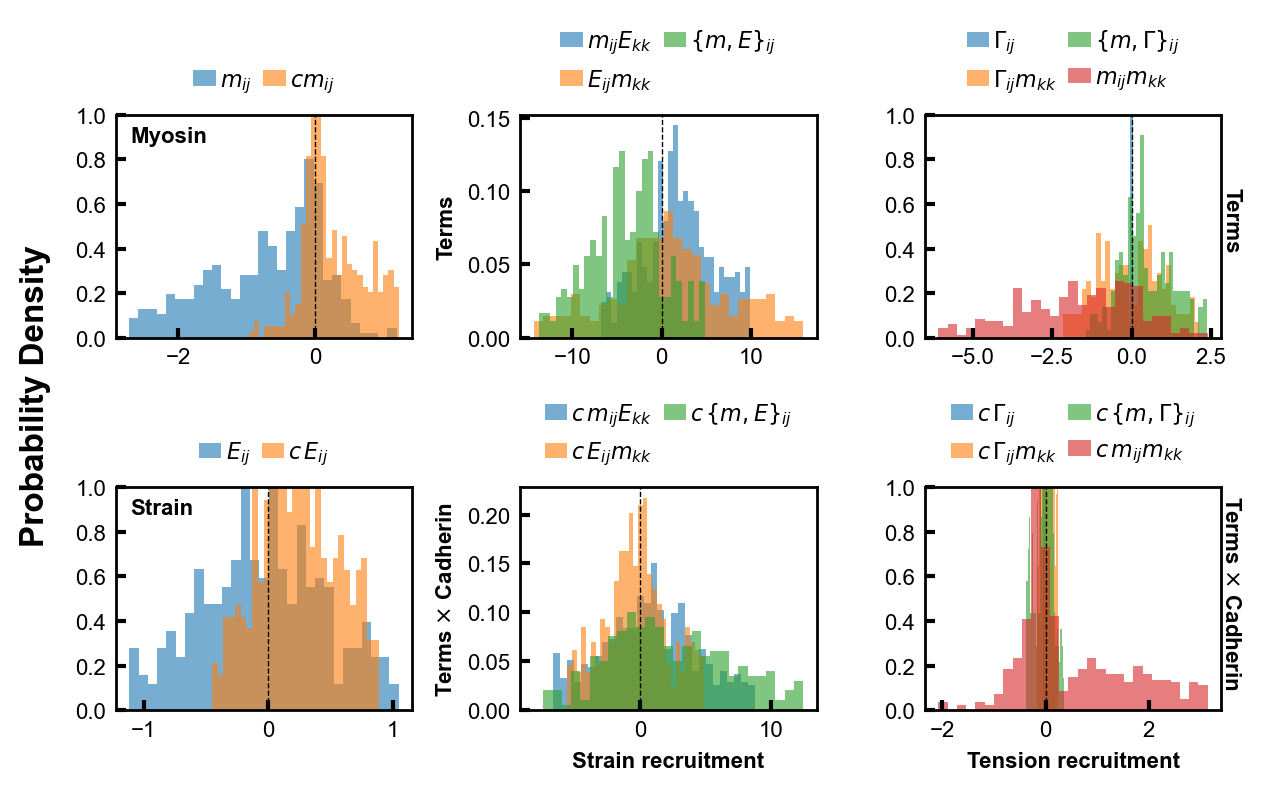

In [247]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['legend.framealpha'] = 0
plt.rcParams['legend.columnspacing'] = .5
plt.rcParams['legend.handletextpad'] = 0.2
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelweight'] = 'bold'

from scipy.stats import iqr
def scatter_terms(ax, terms, labels=None, df=sindy_results, title=''):
    if labels is None: labels = terms
    ylim = 0.
    for i, term in enumerate(terms):
        if not term in df.columns:
            print('Not found in dataframe: ', term)
            ax.plot([0], [0])
            continue
        coef = df[term].values
        coef = coef[np.abs(coef) > 0]
        coef = coef
        med = np.median(coef)
        sep = iqr(coef)
        N = 30
        bins = np.linspace(med-sep, med+sep, N)
        
        ymax = .5 / sep
        ylim = max(ylim, ymax)
        
        n, _, p = ax.hist(coef, label=labels[i], bins=bins, density=True, alpha=0.6, stacked=True)
        #ax.axvline(med, color=p[0].get_facecolor()[:-1], lw=1, linestyle='--')
    ax.legend(ncol=2, bbox_to_anchor=[0.5, 1], loc='lower center')
    ax.axvline(0, color='black', lw=0.5, linestyle='--')
    ax.set_ylim([0, min(1, np.max(ax.get_ylim()))])
    ax.text(0.05, 0.95, title, fontweight='bold', va='top', ha='left', transform=ax.transAxes)

fig, ax = plt.subplots(2, 3, constrained_layout=True, sharey=False)
    
terms = ['m_ij', 'c m_ij']
#sindy_results['m_ij'] *= -1
scatter_terms(ax[0, 0], terms, ['$m_{ij}$', '$c m_{ij}$'], title='Myosin')

terms = ['E_passive', 'c E_passive']
scatter_terms(ax[1, 0], terms, ['$E_{ij}$', '$c\,E_{ij}$'], title='Strain')

terms = ['m_ij Tr(E_passive)', 'E_passive Tr(m_ij)', '{m_ij, E_passive}']
scatter_terms(ax[0, 1], terms, ['$m_{ij} E_{kk}$', '$E_{ij} m_{kk}$', '$\{m, E\}_{ij}$'])

terms = ['c m_ij Tr(E_passive)', 'c E_passive Tr(m_ij)', 'c {m_ij, E_passive}']
scatter_terms(ax[1, 1], terms, ['$c\,m_{ij} E_{kk}$', '$c\,E_{ij} m_{kk}$', '$c\,\{m, E\}_{ij}$'])


terms = ['Static_DV', 'Static_DV Tr(m_ij)', '{m_ij, Static_DV}', 'm_ij Tr(m_ij)']
scatter_terms(ax[0, 2], terms, ['$\Gamma_{ij}$', '$\Gamma_{ij} m_{kk} $', '$\{m, \Gamma\}_{ij}$', '$m_{ij} m_{kk}$'])

terms = ['c Static_DV', 'c Static_DV Tr(m_ij)', 'c {m_ij, Static_DV}', 'c m_ij Tr(m_ij)']
scatter_terms(ax[1, 2], terms, ['$c\,\Gamma_{ij}$', '$c\,\Gamma_{ij} m_{kk} $', '$c\,\{m, \Gamma\}_{ij}$', '$c\,m_{ij} m_{kk}$'])


ax[1, 1].set_xlabel('Strain recruitment')
ax[1, 2].set_xlabel('Tension recruitment')
ax[0, 1].set_ylabel('Terms')
ax[1, 1].set_ylabel('Terms $\\times$ Cadherin')

fig.text(1, 0.53, 'Terms', rotation=-90, 
         va='center', ha='left',
         fontweight='bold', transform=ax[0, -1].transAxes)
fig.text(1, 0.53, 'Terms $\\times$ Cadherin', rotation=-90, 
         va='center', ha='left',
         fontweight='bold', transform=ax[1, -1].transAxes)

fig.text(0, 0.5, 'Probability Density', rotation=90, fontsize=12, fontweight='bold', va='center', ha='right')

plt.tight_layout()